# LRP

LRP(Layer-wise Relevance Propagation, 계층별 타당성 전파)는 

딥러닝 모델의 결과를 역추적해서 입력 이미지에 히트맵(heatmap)을 출력한다.

히트맵은 딥러닝 모델이 입력 이미지를 어떻게 바라보는지 직접 표시하여

블랙박스가 데이터의 어느 곳을 주목하는지 표시할 수 있기 때문에 

피처맵보다 블랙박스를 오인할 가능성이 적다.

<br><br>

LRP는 이론적으로 두 가지 기법이 혼합돼 있는데, 하나는 타당성 전파(Relevance Propagation),

다른 하나는 분해(Decomposition)다. 전파는 특정 결과가 나오게 된 원인을 분해하고 그 비중을 분배하는 과정이다.

분해는 앞서 전파로 얻어낸 원인을 가중치로 환원하고 해부하는 과정이다.

일반적으로 딥러닝은 파라미터가 많아서 직관적으로 모델을 이해하기가 어렵다.

특히 딥러닝 모델은 피처를 연결하고 활성화되는 과정이 비선형적이고, 다양한 커널로 사상되기 때문에 추론하기가 어렵다.

이러한 비선형성을 극복하고 설명성을 부여하기 위해서 필터 시각화나 민감도를 사용하는 기법들이 등장했다.

필터 시각화나 민감도 기법은 딥러닝의 순방향으로 진행하며 데이터 흐름을 관찰하는 기법이다.

LRP는 딥러닝 블랙박스가 분류한 이미지 결과를 역순으로 탐지하며 분해한다.

그리고 마침내 분해된 요소들이 원본 이미지까지 도달했을 때 원본 이미지에 상대적 기여도를 표시함으로써 딥러닝 모델을 해석한다.

LRP는 딥러닝 블랙박스를 역순으로 탐지하기 위해 분해 기법을 사용하고, 기여도를 계산할 때 타당성 전파 기법을 사용한다.

### 분해

분해는 블랙박스에 입력된 피처 하나가 결과 해석에 얼마나 영향을 미치는지 해체하는 방법이다.

분해하면 어떤 이미지 x에서 픽셀 k가 결과를 도출하는 데 도움이 되는지, 해가 되는지를 알아낼 수 있다.

이것을 시각화하면 도움이 되는 영역을 빨간색, 잘못 분류하는 영역을 파란색으로 표시한다.

### 타당성 전파

타당성 전파는 분해 과정을 마친 은닉층이 결과값 출력에 어떤 기여를 하는지 타당성을 계산하는 방법이다.

모델이 분해를 마치고 피처 타당성 계산으로 모든 은닉층 활성화 함수의 기여도를 계산할 수 있다면,

이미지 x의 픽셀마다 기여도를 표시할 수 있다. 

<br><br>

이미지를 분류할 때의 타당성(relevance)는 은닉층 벡터 한 원소의 타당성 점수의 총합으로 계산할 수 있다.

이때, 은닉층 벡터 한 원소의 타당성 점수를 특정 피처의 기여도라고 한다. 이 값이 양수면 예측에 긍정적 영향을 미친다고 해석할 수 있다.

타당성은 마지막 은닉층에서 차례로 입력 데이터까지의 타당성 가중치(기여도의 합)을 계산하는 과정으로 볼 수 있다.

이때 가중치(피처)와 기여도는 방향이 반대고 크기도 다르다. 왜냐면, 가중치는 제한이 없고, 타당성은 비율이기 때문이다.

가중치는 음의 값을 가질 수 있고 타당성은 모두 양의 값을 갖는다.

논문에서는 보존 특성(conservation property)이라는 아이디어를 사용해 각 타당성 계층 간 총합이 일치하게 했다.

타당성은 양방향으로 계산할 수 있어서 타당성 전파 간선 값을 양쪽으로 추론할 수 있다.

궁극적으로 계산해야 할 입력 이미지 영역 상대성은 입력 이미지 다음 레이어의 은닉층 타당성 전파 간선을 계산해 구할 수 있다.

또한, 은닉층의 타당성 전파 간선은 딥러닝 모델 전체의 타당성 전파 간선으로부터 구할 수 있다.

<br>

각 은닉층별 가중치 합이 다르고, 마지막 계층의 결괏값에 기여한 각 은닉층별 가중치 비율을 계산한다면 타당성 간선을 분해할 수 있을 것이다.

신경망 분류 결괏값은 바로 직전 은닉층의 가중치와 활성화 함수의 합으록 구할 수 있다.

신경망의 마지막 분류 결과를 각각의 활성함수와 가중치 합으로 정규화를 하고 타당성 전파를 계산한다.

그러면 각 은닉층을 잇는 타당성 간선의 합은 신경망의 마지막 분류 결괏값과 같아질 뿐만 아니라, 

가중치와 활성화 함수 값으로부터 타당성 전파 간선 값을 계산할 수 있다.

이렇게 구한 타당성 전파 간선 값을 모으면 타당성 변수를 계산할 수 있다.

In [1]:
# 합성곱 신경망을 제작하고 정확도를 출력하는 코드

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import tensorflow.contrib.slim as slim
from tensorflow.examples.tutorials.mnist import input_data

import warnings
warnings.filterwarnings(action='ignore')

# 메모리 할당 문제 해결
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

# MNIST 데이터셋 로드
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

# CNN 모델 구성
tf.reset_default_graph()
x = tf.placeholder(tf.float32, [None, 784], name="x-in")
true_y = tf.placeholder(tf.float32, [None, 10], name="y-in")
keep_prob = tf.placeholder('float')
x_image = tf.reshape(x, [-1,28,28,1])

# 첫 번째 계층
hidden_1 = slim.conv2d(x_image, 5, [5,5])
pool_1 = slim.max_pool2d(hidden_1, [2,2])

# 두 번째 계층
hidden_2 = slim.conv2d(pool_1, 5, [5,5])
pool_2 = slim.max_pool2d(hidden_2, [2,2])

# 세 번째 계층
hidden_3 = slim.conv2d(pool_2, 20, [5,5])
hidden_3 = slim.dropout(hidden_3, keep_prob)

out_y = slim.fully_connected(slim.flatten(hidden_3),
                             10, activation_fn = tf.nn.softmax)

cross_entropy = -tf.reduce_sum(true_y * tf.log(out_y))
correct_prediction = tf.equal(tf.argmax(out_y,1), tf.argmax(true_y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

# 학습
batchSize=50
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

for i in range(1000):
    batch = mnist.train.next_batch(batchSize)
    sess.run(train_step,
            feed_dict = {x:batch[0],true_y:batch[1], keep_prob:0.5})
    if i % 100 == 0 and i != 0:
        trainAccuracy = sess.run(accuracy,
                                feed_dict = {x:batch[0],true_y:batch[1], keep_prob:1.0})
        print("step %d, training accuracy %g"%(i, trainAccuracy))


# 정확도 계산
testAccuracy = sess.run(accuracy,
                       feed_dict = {x:mnist.test.images,
                                   true_y: mnist.test.labels,
                                   keep_prob:1.0})
print("test accuracy %g"%(testAccuracy))

W1231 19:07:23.747939 139953723848512 deprecation.py:323] From <ipython-input-1-34b33dccf23d>:28: read_data_sets (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
W1231 19:07:23.749419 139953723848512 deprecation.py:323] From /root/anaconda3/envs/xai/lib/python3.6/site-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:260: maybe_download (from tensorflow.contrib.learn.python.learn.datasets.base) is deprecated and will be removed in a future version.
Instructions for updating:
Please write your own downloading logic.
W1231 19:07:23.750274 139953723848512 deprecation.py:323] From /root/anaconda3/envs/xai/lib/python3.6/site-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:262: extract_images (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in 

1 Physical GPUs, 1 Logical GPUs
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


W1231 19:07:24.281749 139953723848512 deprecation.py:323] From /root/anaconda3/envs/xai/lib/python3.6/site-packages/tensorflow/contrib/layers/python/layers/layers.py:1634: flatten (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.flatten instead.


step 100, training accuracy 0.48
step 200, training accuracy 0.66
step 300, training accuracy 0.84
step 400, training accuracy 0.82
step 500, training accuracy 0.86
step 600, training accuracy 0.92
step 700, training accuracy 0.86
step 800, training accuracy 0.88
step 900, training accuracy 0.9
test accuracy 0.8959


LRP를 구현하는 데 필요한 변수들은 아래와 같다.

1. 신경망의 계층별 활성화 함수

2. 신경망의 두 계층 사이를 잇는 가중치 벡터

3. 분류 결괏값

4. 신경망의 앞 계층 노드별 타당성 수치

1~3번 변수는 텐서플로우 라이브러리로 쉽게 얻을 수 있다.

4번 변수는 3번과 2번을 가공해서 구할 수 있다.

In [21]:
# 필요 변수 1, 2를 불러오는 코드

layers = [hidden_1, pool_1, hidden_2, pool_2, hidden_3]
weights = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                           scope='.*weights.*')
biases = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                           scope='.*biases.*')

In [22]:
# 계층별 활성화 함수 결과를 출력하는 코드
def getActivations(layer, image):
    units = sess.run(layer,
                    feed_dict = {x: np.reshape(image,
                                              [1,784],
                                              order='F'),
                                keep_prob: 1.0})
    return units

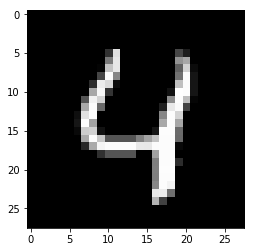

In [23]:
# 테스트 이미지 출력
idx = 4
imageToUse = mnist.test.images[idx]
plt.imshow(np.reshape(imageToUse, [28,28]), interpolation = 'nearest', cmap='gray')

In [24]:
# 합성곱 신경망의 은닉 계층마다 활성화 함수를 구하는 코드

activations = []
for layer in layers:
    activations.append(getActivations(layer, imageToUse))

In [25]:
# 합성곱 신경망에 이미지를 입력하고 out_y 예측 결과를 구하는 코드

predict = sess.run(out_y, feed_dict= {x: imageToUse.reshape([-1, 784]),
                                     keep_prob: 1.0})[0]

idx = 0
for i in predict:
    print('[{}] {:.2%}'.format(idx, i))
    idx+=1

# 변수 3번
f_x = max(predict)
print(f_x)

[0] 0.10%
[1] 0.00%
[2] 0.30%
[3] 0.04%
[4] 86.65%
[5] 0.10%
[6] 0.61%
[7] 0.59%
[8] 0.19%
[9] 11.43%
0.86646086


86.64%라는 수치는 LRP의 타당성에 해당한다. 

이제 LRP는 합성곱 신경망의 은닉 계층을 역으로 방문하면서 타당성 수치를 분해한다.

In [26]:
# R4(마지막 계층 타당성 수치)

R4 = predict
R4.shape

(10,)

R3까지 타당성 전파를 구하기 위해서는 FC 계층의 기울기를 계싼하고 타당성 벡터를 곱해야 한다.

In [27]:
# FC 연결에서 LRP를 수행하는 코드.

def backprop_dense(activation, weight, bias, relevance):
    w = tf.maximum(0., weight)
    b = tf.maximum(0., bias)
    z = tf.matmul(activation, w) + b
    
    s = relevance / z
    c = tf.matmul(s, tf.transpose(w))
    return activation * c

activation은 활성화 함수로, R3를 구할 때는 합성곱 은닉층 3층의 노드가 들어간다.

weight 파라미터에는 합성곱 은닉 3층과 out_y 사이를 이어주는 가중치,

bias 파라미터에는 바이어스가 들어간다.

In [28]:
# LRP 공식으로 R3를 구하는 코드

a = activations.pop()
w = weights.pop()
b = biases.pop()
print(a.shape)
print(w.shape)
R3 = backprop_dense(a.reshape(1,980),w, b, R4)
print(R3.shape)

(1, 7, 7, 20)
(980, 10)
(1, 980)


R3는 out_y 계층과 FC의 관계다. 이 관계는 생략되거나 사라지는 연산이 없으므로 계산하기 쉽다.

그러나 R2, R1은 Deconvolution, Unpooling 과정을 수행해야 한다.

In [29]:
# 언풀링 연산에서 LRP를 구하는 코드

from tensorflow.python.ops import gen_nn_ops

def backprop_pooling(activation, relevance):
    # 커널 사이즈, 스트라이드
    # z값이 0일 때를 대비해 1e-10을 더한다.
    ksize = strides = [1,2,2,1] # 기본값이었으므로 이렇게 해줌. 풀링 스트라이드, 커널 크기 바꾸면 바꿔야 함
    z = tf.nn.max_pool(activation, ksize, strides, padding = 'SAME') + 1e-10
    s = relevance / z
    
    c = gen_nn_ops.max_pool_grad(activation, z, s, ksize, strides, padding='SAME')
    return activation * c


In [30]:
# 역합성곱 연산에서 LRP를 구하는 코드

def backprop_conv(activation, weight, bias, relevance):
    strides = [1,1,1,1]# 기본값이었으므로 이렇게 해줌. 합성곱 스트라이드 크기 바꾸면 바꿔야 함
    w = tf.maximum(0., weight)
    b = tf.maximum(0., bias)
    z = tf.nn.conv2d(activation, w, strides, padding='SAME')
    z = tf.nn.bias_add(z, b)
    s = relevance /z
    c = tf.nn.conv2d_backprop_input(tf.shape(activation), w, s, strides, padding='SAME')
    return activation * c

In [31]:
# R3 벡터로부터 역합성곱과 언풀링 연산을 수행하고 R2 벡터를 구하는 코드

w = weights.pop()
b = biases.pop()
p = activations.pop()
a = activations.pop()
print(p.shape)

R_conv = backprop_conv(p, w, b, tf.reshape(R3, [1,7,7,20]))
print(R_conv)
R2 = backprop_pooling(a, R_conv)
print(R2.shape)

(1, 7, 7, 5)
Tensor("mul_4:0", shape=(1, 7, 7, 5), dtype=float32)
(1, 14, 14, 5)


In [32]:
# R2에서 역합성곱과 언풀링 과정을 수행하고 R1 벡터를 구하는 코드

w = weights.pop()
b = biases.pop()
p = activations.pop()
a = activations.pop()


R_conv = backprop_conv(p, w, b, R2)
print(R_conv)

R1 = backprop_pooling(a, R_conv)
print(R1.shape)
print(np.sum(sess.run(R1)))

Tensor("mul_6:0", shape=(1, 14, 14, 5), dtype=float32)
(1, 28, 28, 5)
0.98482364


In [33]:
# R1 결과에서 원본 이미지까지 LRP를 수행하는 코드

img_activations = getActivations(x_image, imageToUse)
w = weights.pop()
b = biases.pop()
R0 = backprop_conv(img_activations, w, b, R1)
LRP_out = sess.run(R0)

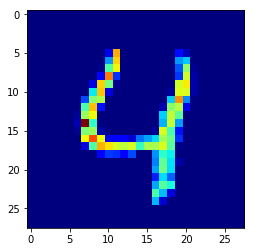

In [34]:
# 원본 이미지 형태로 타당성 전파를 수행하고 결과물을 이미지 형태로 출력하는 코드

plt.imshow(LRP_out.reshape(28,28), interpolation = "nearest", cmap=plt.cm.jet)

In [35]:
# 합성곱 신경망 전체에 대해 LRP를 수행하는 코드

def getLRP(img):
    
    predict = sess.run(out_y, feed_dict= {x: imageToUse.reshape([-1, 784]),
                                          keep_prob: 1.0})[0]
    layers = [hidden_1, pool_1, hidden_2, pool_2, hidden_3]
    weights = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                scope='.*weights.*')
    biases = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 
                               scope='.*biases.*')
    activations = []
    for layer in layers:
        activations.append(getActivations(layer, imageToUse))
        
    # f_x 구하기
    f_x = max(predict)
    
    #R4 구하기
    predict[predict < 0 ] = 0
    R4 = predict
    
    #R3 구하기
    a = activations.pop()
    w = weights.pop()
    b = biases.pop()
    R3 = backprop_dense(a.reshape(1,980),w, b, R4)
    
    #R2 구하기
    w = weights.pop()
    b = biases.pop()
    p = activations.pop()
    a = activations.pop()
    R_conv = backprop_conv(p, w, b, tf.reshape(R3, [1,7,7,20]))
    R1 = backprop_pooling(a, R_conv)

    #R1 구하기
    w = weights.pop()
    b = biases.pop()
    p = activations.pop()
    a = activations.pop()
    R_conv = backprop_conv(p, w, b, R2)
    R1 = backprop_pooling(a, R_conv)
    
    #R1 구하기
    img_activations = getActivations(x_image, img)
    w = weights.pop()
    b = biases.pop()
    R0 = backprop_conv(img_activations, w, b, R1)
    LRP_out = sess.run(R0)
    return LRP_out

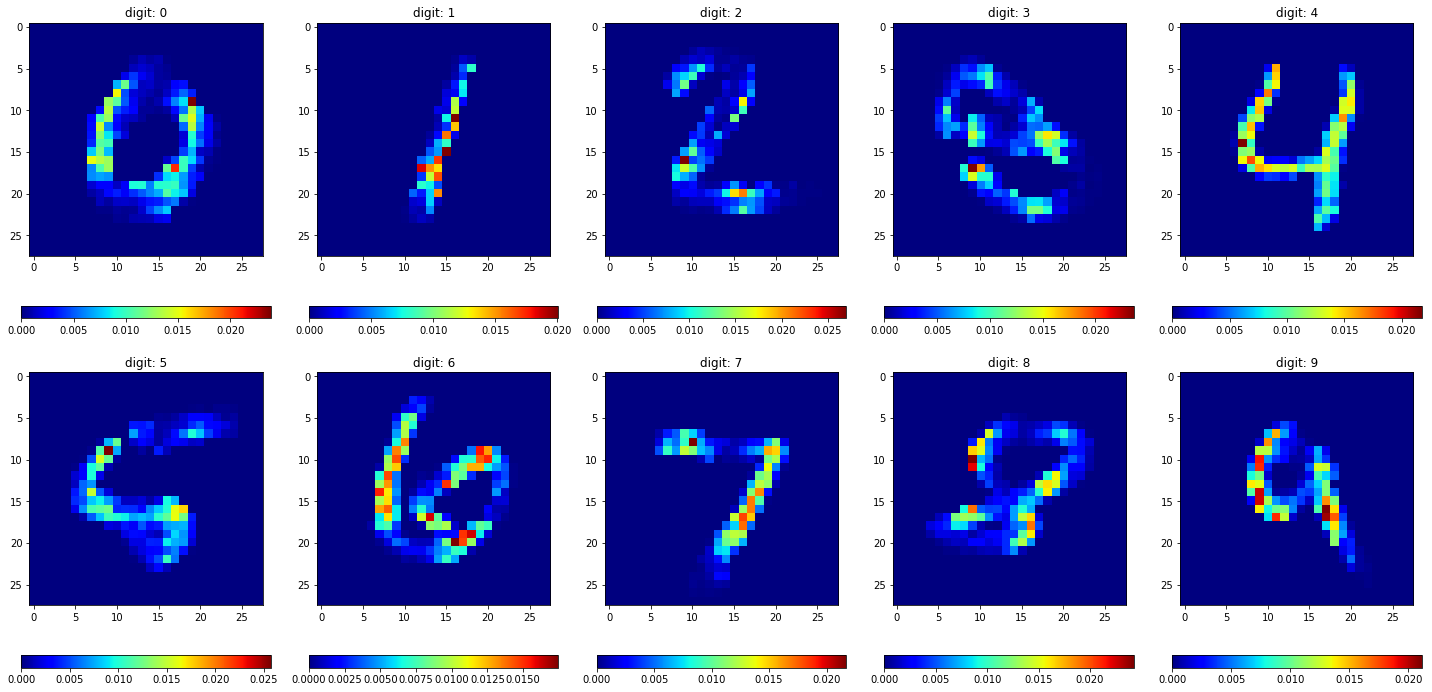

In [36]:
# MNIST 손글씨 이미지에서 숫자별로 이미지를 입력받고 LRP를 수행하는 코드

mnist_dict = {}
idx = 0

for i in mnist.test.labels:
    label = np.where(i == np.amax(i))[0][0]
    
    if mnist_dict.get(label):
        mnist_dict[label].append(idx)
    else:
        mnist_dict[label] = [idx]
        
    idx += 1

nums = []
for i in range(10):
    img_idx = mnist_dict[i][0]
    img = mnist.test.images[img_idx]
    
    lrp = getLRP(img)
    nums.append(lrp)

plt.figure(figsize = (20,10))
for i in range(2):
    for j in range(5):
        idx = 5 * i + j
        plt.subplot(2, 5, idx + 1)
        plt.title("digit: {}".format(idx))
        plt.imshow(nums[idx].reshape([28,28]), cmap=plt.cm.jet)
        plt.colorbar(orientation = 'horizontal')
plt.tight_layout()
sess.close()

위 그림에 의하면 합성곱 신경망은 손글씨 0을 인식할 때 전체적인 굴곡을 주로 인식한다.

손글시 이미지 1의 경우 모델은 획의 직선성을 중시한다.

LRP를 통해 합성곱 신경망은 클래스별로 서로 다른 부위와 조합을 인식한다는 것을 확인할 수 있다.

이처럼 LRP를 이용하면 일반적인 이미지 입력-결과만으로는 알 수 없는 딥러닝의 인식 범주를 직접 확인할 수 있다.

필터 시각화 기법은 은닉층을 시각화해서 모델의 학습 정도를 표시한다.

반면 LRP는 모델이 데이터의 어떤 부분을 집중해서 해석하는가를 시각적으로 표현한다.

LRP기법은 2015년에 등장했다.

오늘날 신경망 해석 기법은 LRP 말고도 많은데, 대부분은 LRP의 핵심 요소였던 타당성 전파와 분해를 응용한 기술이다.

깊은 테일러 분해(Deep Taylor Decomposition), CAM(Class Activation mapping), Grad-CAM, LIFT(Learned Invariant Feature Transform) 등의 기법도 있다. 